In [1]:
%%capture
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Install nomad from local folder (remember to restart kernel after first installation!)

In [2]:
%%capture
!pip install -e ../../tools/nomad/

In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot
import tools.util_imputation as nmd_imp

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import kendalltau
import importlib
import logging

In [4]:
# logging has to manually turned on to see nomad output
logging.basicConfig(level=logging.INFO)

In [ ]:
data_path = "../data/S3"
figure_path = f"{data_path}/figures/imputation"
layer = "counts"

In [ ]:
data_counts = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_and_pca.h5ad")
data_counts

In [6]:
expr_class = pd.read_csv(
    "../../data/control_expression_classification.tsv", delimiter="\t"
)
expr_class.set_index(keys="locus_tag", inplace=True)
expr_class

,Name,tpm,expression_level,log_tpm
locus_tag,,,,
PA0001,dnaA,333.097801,high,8.379802
PA0002,dnaN,299.127321,high,8.224616
PA0003,recF,128.151975,medium_high,7.001712
PA0004,gyrB,138.579052,medium_high,7.114565
PA0005,lptA,141.413217,medium_high,7.143773
...,...,...,...,...
PA5566,PA5566,45.077831,medium_low,5.494346
PA5567,PA5567,49.149167,medium_low,5.619095
PA5568,PA5568,208.178186,high,7.701675


- `mean_counts`: mean gene expression
- `n_cells`: number of cells that express gene (so (n - `n_cells`) / n = sparsity)

In [7]:
data_counts.var = data_counts.var.join(expr_class)
data_counts.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,nb_overdisp,nb_overdisp_cutoff,nb_overdisp_cutoff_bfgs,nb_overdisp_bfgs,mean,std,Name,tpm,expression_level,log_tpm
PA0001,Gene Expression,PA01,735,0.666451,0.510696,52.396373,1029.0,6.937314,735,0.755973,...,18.111393,18.111393,5.594172,5.594172,1.601548,0.118538,dnaA,333.097801,high,8.379802
PA0002,Gene Expression,PA01,541,0.468912,0.384522,64.961140,724.0,6.586172,541,0.588412,...,12.464359,12.464359,2.098157,2.098157,1.223343,0.143616,dnaN,299.127321,high,8.224616
PA0003,Gene Expression,PA01,890,0.893782,0.638576,42.357513,1380.0,7.230563,890,1.043122,...,18.981845,18.981845,6.142867,6.142867,1.673568,0.126803,recF,128.151975,medium_high,7.001712
PA0004,Gene Expression,PA01,463,0.373705,0.317511,70.012953,577.0,6.359574,463,0.398557,...,9.771475,9.771475,4.994042,4.994042,0.975656,0.150255,gyrB,138.579052,medium_high,7.114565
PA0005,Gene Expression,PA01,173,0.120466,0.113745,88.795337,186.0,5.231109,173,0.124089,...,2.303056,2.303056,4.006021,4.006021,-0.471043,0.257162,lptA,141.413217,medium_high,7.143773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,Gene Expression,PA01,14,0.009715,0.009668,99.093264,15.0,2.772589,14,0.010916,...,0.110345,0.110345,0.071678,0.071678,-3.560666,0.320679,PA5566,45.077831,medium_low,5.494346
PA5567,Gene Expression,PA01,163,0.126943,0.119509,89.443005,196.0,5.283204,163,0.161347,...,2.319421,2.319421,0.446582,0.446582,-0.462726,0.269982,PA5567,49.149167,medium_low,5.619095
PA5568,Gene Expression,PA01,740,0.659974,0.506802,52.072539,1019.0,6.927558,740,0.750315,...,18.054091,18.054091,6.271350,6.271350,1.597712,0.118556,PA5568,208.178186,high,7.701675
PA5569,Gene Expression,PA01,1430,3.498057,1.503646,7.383420,5401.0,8.594525,1430,14.170981,...,6.450312,6.450312,1.843350,1.843350,1.303270,0.373673,rnpA,3387.343294,high,11.725938


## Fit NMD

In [8]:
data_layer = "counts"

latent_rank = 5
momentum_beta = 0.4
max_iterations = 500

init_strat = InitializationStrategy.ROWWISE_MEAN
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

In [9]:
m, n = data_counts.X.shape
X_nmd = ut.convert_to_dense_counts(data_counts, layer=data_layer)

In [10]:
result = nmd.decompose(
    X_nmd,
    latent_rank,
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernelInputTypes.Momentum3BlockAdditionalParameters(
        momentum_beta=momentum_beta
    ),
    manual_max_iterations=max_iterations,
    verbose=True,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None
INFO:fi_nomad.entry:500 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 64.88491856912151 loop took 162.12066987156868 overall (0.32424133974313735/ea)


In [11]:
result.factors[1].shape

(5, 5553)

In [12]:
data_counts.obsm["X_nmd"] = result.factors[0]
data_counts.varm["NMD_components"] = result.factors[1].T
data_counts.layers["Theta"] = result.factors[0] @ result.factors[1]

In [14]:
data_counts.layers["Theta"].min()

-28.888172327321474

In [180]:
gene_pairs = nmd_imp.sample_gene_pairs(
    data_counts,
    n=50,
    measure_var=["mean_counts", "pct_dropout_by_counts"],
    expr_lvls=["low", "medium_high"],
)
plot_df = nmd_imp.make_gene_pair_df(gene_pairs, data_counts, cutoff=0.0)

In [181]:
# plot_df_agg = plot_df.groupby(["id", "expression_lvl_class"])["Expression"].quantile(0.25).reset_index()

plot_df_agg = (
    plot_df.groupby(["id", "expression_lvl_class"])["Expression"].median().reset_index()
)
plot_df_agg_wide = plot_df_agg.pivot(
    index="id", columns="expression_lvl_class", values="Expression"
).reset_index()
print((plot_df_agg_wide["low"].isna()).value_counts())

# print((plot_df_agg_wide["medium_high"].isna()).value_counts())

False    38
True      8
Name: low, dtype: int64


### Mach ne funktion daraus

In [182]:
plot_df_agg_wide.head()

expression_lvl_class,id,low,medium_high
0,0,-0.011199,-0.005009
1,1,NaN,-0.013371
2,2,-0.000918,-0.001324
3,3,-0.005437,-0.003479
4,4,-0.008157,NaN


In [183]:
plot_df_agg_wide["diff"] = plot_df_agg_wide["low"] - plot_df_agg_wide["medium_high"]
plot_df_agg_wide["order"] = plot_df_agg_wide["diff"].rank(ascending=False)

In [184]:
plot_df_agg_wide = plot_df_agg_wide.melt(
    id_vars=["id", "diff", "order"],
    var_name="expression_lvl_class",
    value_name="Expression",
)

<Axes: xlabel='diff', ylabel='Count'>

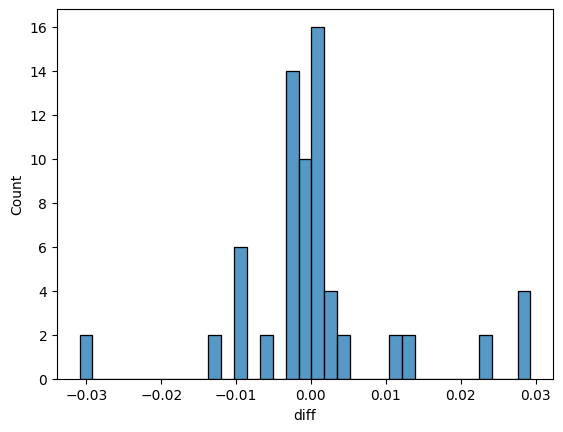

In [185]:
sns.histplot(plot_df_agg_wide, x="diff")

In [95]:
# plot_df["id"] = plot_df["id"].astype(str)
# sns.catplot(plot_df, x = "Expression", y = "id", hue = "expression_lvl_class", kind="violin", split="True", cut=0)

In [171]:
# plot_df_agg_wide = plot_df_agg_wide.join(plot_df[["id", "dist"]].set_index("id"), on="id")

ValueError: cannot reindex on an axis with duplicate labels

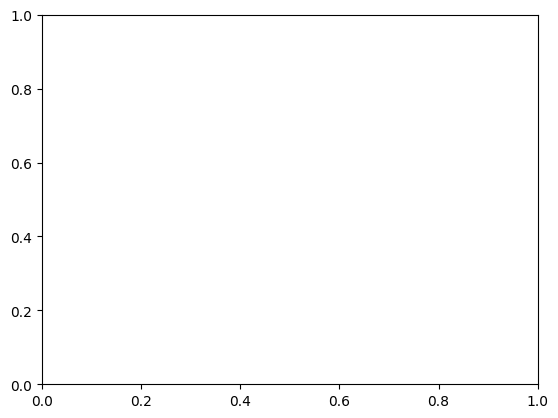

In [172]:
sns.scatterplot(plot_df_agg_wide, x="diff", y="order", hue=plot_df_agg_wide["diff"])
plt.vlines([0.0], ymin=0, ymax=plot_df_agg_wide["order"].max(), colors="black")

Order auf y-Achse: mal versuchen die closeness als order

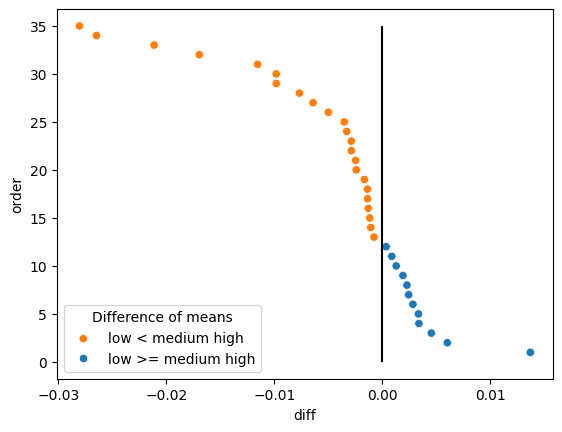

In [98]:
sns.scatterplot(plot_df_agg_wide, x="diff", y="order", hue=plot_df_agg_wide["diff"] < 0)
plt.legend(
    title="Difference of means",
    loc="lower left",
    labels=["low < medium high", "low >= medium high"],
)
plt.vlines([0.0], ymin=0, ymax=plot_df_agg_wide["order"].max(), colors="black")

<Axes: xlabel='Expression', ylabel='order'>

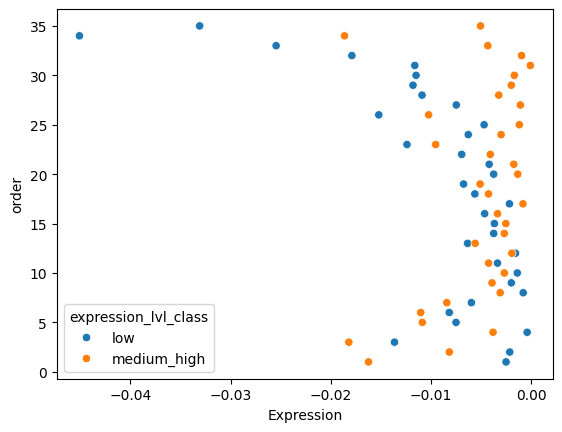

In [99]:
sns.scatterplot(plot_df_agg_wide, x="Expression", y="order", hue="expression_lvl_class")
# plt.legend(title='Difference of means', loc='lower left', labels=['low < medium high', 'low >= medium high'])

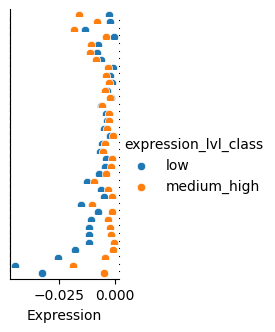

In [100]:
g = sns.FacetGrid(
    plot_df_agg_wide, row="order", hue="expression_lvl_class", aspect=15, height=0.1
)
g.map(sns.scatterplot, "Expression", y=0.0, legend="full")
g.figure.subplots_adjust(hspace=-0.3)
g.add_legend()
g.set_titles("")
g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

### NMD latent rank 10

In [38]:
latent_rank_10 = 10
max_iterations_rank_10 = 1000

init_strat_rank_10 = InitializationStrategy.ROWWISE_MEAN
kernel_strat_rank_10 = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

result_rank_10 = nmd.decompose(
    X_nmd,
    latent_rank_10,
    kernel_strategy=kernel_strat_rank_10,
    initialization=init_strat,
    kernel_params=kernelInputTypes.Momentum3BlockAdditionalParameters(
        momentum_beta=momentum_beta
    ),
    manual_max_iterations=max_iterations_rank_10,
    verbose=True,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None
INFO:fi_nomad.entry:1000 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 64.86208710214123 loop took 372.27361164195463 overall (0.3722736116419546/ea)


In [40]:
data_counts_rank_10 = data_counts.copy()

data_counts_rank_10.obsm["X_nmd"] = result_rank_10.factors[0]
data_counts_rank_10.varm["NMD_components"] = result_rank_10.factors[1].T
data_counts_rank_10.layers["Theta"] = (
    result_rank_10.factors[0] @ result_rank_10.factors[1]
)

In [62]:
gene_pairs_rank_10 = sample_gene_pairs(
    data_counts_rank_10,
    n=250,
    measure_var=["mean_counts"],
    expr_lvls=["low", "medium_high"],
)
plot_df_rank_10 = make_gene_pair_df(gene_pairs_rank_10, data_counts_rank_10, cutoff=0.0)

plot_df_agg_rank_10 = (
    plot_df_rank_10.groupby(["id", "expression_lvl_class"])["Expression"]
    .mean()
    .reset_index()
)
plot_df_agg_wide_rank_10 = plot_df_agg_rank_10.pivot(
    index="id", columns="expression_lvl_class", values="Expression"
)  # .fillna(0.0)
print((plot_df_agg_wide_rank_10["low"].isna()).value_counts())

False    239
True       5
Name: low, dtype: int64


In [63]:
plot_df_agg_wide_rank_10["diff"] = (
    plot_df_agg_wide_rank_10["low"] - plot_df_agg_wide_rank_10["medium_high"]
)
plot_df_agg_wide_rank_10["order"] = plot_df_agg_wide_rank_10["diff"].rank(
    ascending=False
)
plot_df_agg_wide_rank_10 = plot_df_agg_wide_rank_10.melt(
    id_vars=["diff", "order"], var_name="expression_lvl_class", value_name="Expression"
)

<Axes: xlabel='diff', ylabel='Count'>

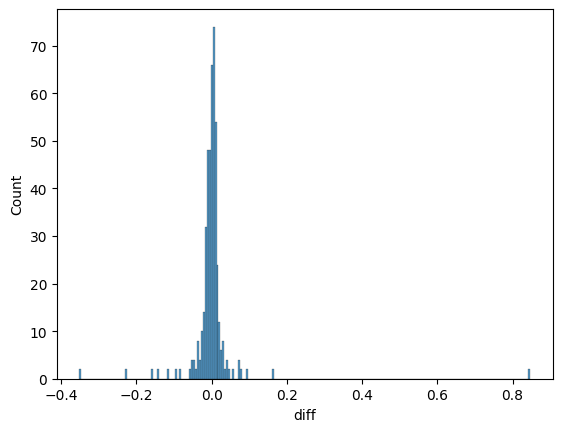

In [64]:
sns.histplot(plot_df_agg_wide_rank_10, x="diff")

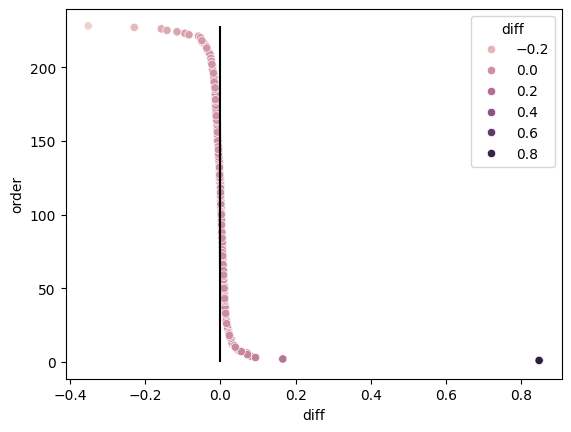

In [65]:
sns.scatterplot(
    plot_df_agg_wide_rank_10, x="diff", y="order", hue=plot_df_agg_wide_rank_10["diff"]
)
plt.vlines([0.0], ymin=0, ymax=plot_df_agg_wide_rank_10["order"].max(), colors="black")

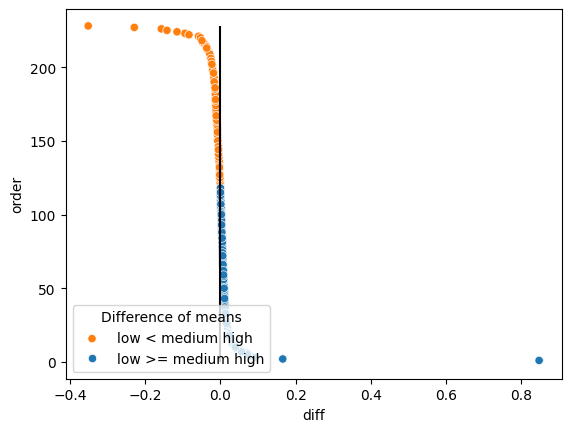

In [66]:
sns.scatterplot(
    plot_df_agg_wide_rank_10,
    x="diff",
    y="order",
    hue=plot_df_agg_wide_rank_10["diff"] < 0,
)
plt.legend(
    title="Difference of means",
    loc="lower left",
    labels=["low < medium high", "low >= medium high"],
)
plt.vlines([0.0], ymin=0, ymax=plot_df_agg_wide_rank_10["order"].max(), colors="black")

### NMD latent rank 5, 2000 iter

In [47]:
latent_rank_5 = 5
max_iterations_rank_5 = 2000

init_strat_rank_5 = InitializationStrategy.ROWWISE_MEAN
kernel_strat_rank_5 = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

result_rank_5 = nmd.decompose(
    X_nmd,
    latent_rank_5,
    kernel_strategy=kernel_strat_rank_5,
    initialization=init_strat_rank_5,
    kernel_params=kernelInputTypes.Momentum3BlockAdditionalParameters(
        momentum_beta=momentum_beta
    ),
    manual_max_iterations=max_iterations_rank_5,
    verbose=True,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None
INFO:fi_nomad.entry:2000 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 64.72395269107074 loop took 673.9143790812232 overall (0.3369571895406116/ea)


In [48]:
data_counts_rank_5 = data_counts.copy()

data_counts_rank_5.obsm["X_nmd"] = result_rank_5.factors[0]
data_counts_rank_5.varm["NMD_components"] = result_rank_5.factors[1].T
data_counts_rank_5.layers["Theta"] = result_rank_5.factors[0] @ result_rank_5.factors[1]

In [67]:
gene_pairs_rank_5 = sample_gene_pairs(
    data_counts_rank_5,
    n=250,
    measure_var=["mean_counts"],
    expr_lvls=["low", "medium_high"],
)
plot_df_rank_5 = make_gene_pair_df(gene_pairs_rank_5, data_counts_rank_5, cutoff=0.0)

plot_df_agg_rank_5 = (
    plot_df_rank_5.groupby(["id", "expression_lvl_class"])["Expression"]
    .mean()
    .reset_index()
)
plot_df_agg_wide_rank_5 = plot_df_agg_rank_5.pivot(
    index="id", columns="expression_lvl_class", values="Expression"
)  # .fillna(0.0)
print((plot_df_agg_wide_rank_5["low"].isna()).value_counts())

False    196
True      30
Name: low, dtype: int64


In [68]:
plot_df_agg_wide_rank_5["diff"] = (
    plot_df_agg_wide_rank_5["low"] - plot_df_agg_wide_rank_5["medium_high"]
)
plot_df_agg_wide_rank_5["order"] = plot_df_agg_wide_rank_5["diff"].rank(ascending=False)
plot_df_agg_wide_rank_5 = plot_df_agg_wide_rank_5.melt(
    id_vars=["diff", "order"], var_name="expression_lvl_class", value_name="Expression"
)

<Axes: xlabel='diff', ylabel='Count'>

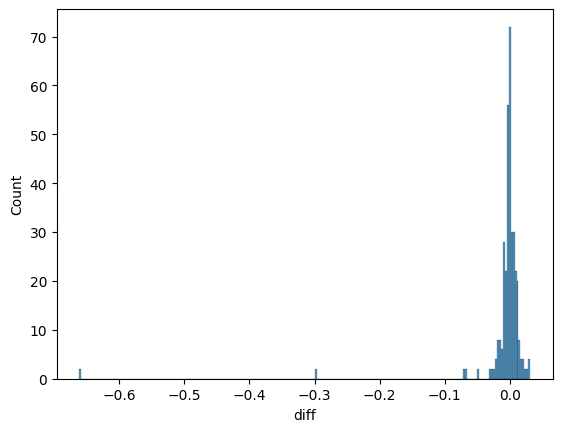

In [69]:
sns.histplot(plot_df_agg_wide_rank_5, x="diff")

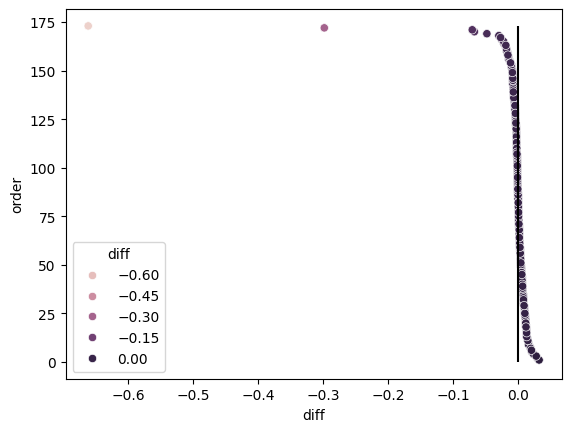

In [70]:
sns.scatterplot(
    plot_df_agg_wide_rank_5, x="diff", y="order", hue=plot_df_agg_wide_rank_5["diff"]
)
plt.vlines([0.0], ymin=0, ymax=plot_df_agg_wide_rank_5["order"].max(), colors="black")

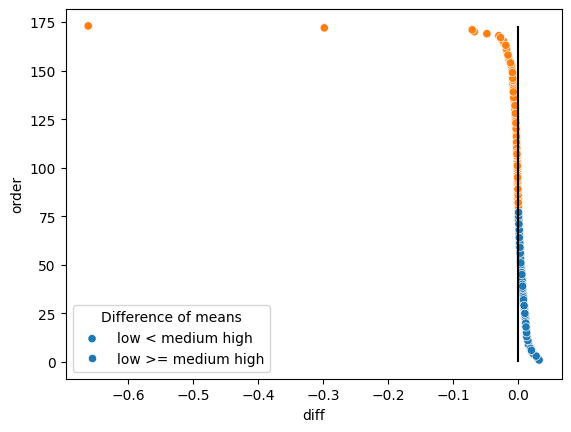

In [71]:
sns.scatterplot(
    plot_df_agg_wide_rank_5,
    x="diff",
    y="order",
    hue=plot_df_agg_wide_rank_5["diff"] < 0,
)
plt.legend(
    title="Difference of means",
    loc="lower left",
    labels=["low < medium high", "low >= medium high"],
)
plt.vlines([0.0], ymin=0, ymax=plot_df_agg_wide_rank_5["order"].max(), colors="black")